## Fully connected LSTM

Background: Since, we are predicting the future trajectory of a storm through time it makes the most sense if we use a neural network that suits sequential dataset. This has inspired us to use LSTM. The way the algorithm works is by converting the images(2D) into a 1 dimensional array, put it into the LSTM model and predict the next step and convert it back to the same 2D image.

Installing required dependencies, and connect our API key inorder to download the data later on.

In [1]:
## Pre-installation
! pip install radiant-mlhub
! pip install livelossplot
! pip install pytorch-msssim
! pip install -q pycm livelossplot
%pylab inline
! pip install pycm
! mlhub configure
# my API key: 5f67f7a7e9c18910f4718ba4db64d107850aec565adbe587aca3bd99a8c0e1a4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Populating the interactive namespace from numpy and matplotlib
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


We import all the required packages including the modules we have created in a folder called tools. (Note: importing in local machine and in colab is different because in google colab we cannot install our created module, but you can do this in a local environment)

In [2]:
# imports
import os
import tarfile
from sklearn.metrics import accuracy_score

import numpy as np
import random
from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import MNIST
from torch.utils.data import Dataset
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, ToPILImage
from radiant_mlhub import Dataset
from torchvision.transforms.transforms import Resize
from torchvision import transforms
from PIL import Image as pil_image

# Importing team's Andrew module for local machine(after installing our modules)
# import tools.dataprocessing as dataprocessing
# import tools.visualisation as visualisation
# import tools.fc_lstm as fc_lstm

# For colab it is not possible to setup the model so we just load the py files directly
import dataprocessing as dataprocessing
import visualisation as visualisation
import fc_lstm as fc_lstm


device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!
Cuda installed! Running on GPU!


# Downloading the dataset

We download the data using the ML_hub library and extract all the files into the current directory

In [4]:
# Download the dataset
os.environ['MLHUB_API_KEY'] = '5f67f7a7e9c18910f4718ba4db64d107850aec565adbe587aca3bd99a8c0e1a4'
dataset = Dataset.fetch('nasa_tropical_storm_competition')
for c in dataset.collections:
    print(c.id)

# download the dataset
dataset.download(output_dir='.')

# unzip the dataset
for path, directories, files in os.walk('./'):
    for f in files:
        if f.endswith(".tar.gz"):
            tar = tarfile.open(os.path.join(path,f), 'r:gz')
            tar.extractall(path=path)
            tar.close()

We load the training and testing data to a variable called "train_df" and "test_df". We merge the training and testing data together inorder to create a full dataset and add two additional columns called file_name and images_per_storm. More information of this function can be found in the docstrings(Andrew.pdf). We will split this data later on

In [3]:
# load, manipulate and combine the dataset
train_df = dataprocessing.Load_data_to_train("nasa_tropical_storm_competition_train_source", "nasa_tropical_storm_competition_train_labels", "./")
test_df = dataprocessing.Load_data_to_test('nasa_tropical_storm_competition_test_source', "./")
full_df = dataprocessing.manipdata(train_df, test_df)

In [4]:
# ! pip install pandas_path
full_df

,Image ID,Storm ID,Relative Time,Ocean,Wind Speed,file_name,images_per_storm
0,abs_000,abs,0,2,43,./nasa_tropical_storm_competition_train_source...,57
1,abs_001,abs,1800,2,44,./nasa_tropical_storm_competition_train_source...,57
2,abs_002,abs,5400,2,45,./nasa_tropical_storm_competition_train_source...,57
3,abs_003,abs,17999,2,52,./nasa_tropical_storm_competition_train_source...,57
4,abs_004,abs,19799,2,53,./nasa_tropical_storm_competition_train_source...,57
...,...,...,...,...,...,...,...
114629,zza_174,zza,378002,1,NaN,./nasa_tropical_storm_competition_train_source...,179
114630,zza_175,zza,379802,1,NaN,./nasa_tropical_storm_competition_train_source...,179
114631,zza_176,zza,381602,1,NaN,./nasa_tropical_storm_competition_train_source...,179
114632,zza_177,zza,383402,1,NaN,./nasa_tropical_storm_competition_train_source...,179


# The storm with the most dataset is fcr

We pick the model with the greatest amount of dataset, which is the fcr storm which has 648 dataset.

In [5]:
full_df[full_df["images_per_storm"] == 648]

,Image ID,Storm ID,Relative Time,Ocean,Wind Speed,file_name,images_per_storm
14886,fcr_000,fcr,0,1,25,./nasa_tropical_storm_competition_train_source...,648
14887,fcr_001,fcr,1800,1,25,./nasa_tropical_storm_competition_train_source...,648
14888,fcr_002,fcr,3600,1,25,./nasa_tropical_storm_competition_train_source...,648
14889,fcr_003,fcr,5401,1,25,./nasa_tropical_storm_competition_train_source...,648
14890,fcr_004,fcr,7200,1,25,./nasa_tropical_storm_competition_train_source...,648
...,...,...,...,...,...,...,...
15529,fcr_643,fcr,1393200,1,20,./nasa_tropical_storm_competition_train_source...,648
15530,fcr_644,fcr,1395000,1,20,./nasa_tropical_storm_competition_train_source...,648
15531,fcr_645,fcr,1396800,1,20,./nasa_tropical_storm_competition_train_source...,648
15532,fcr_646,fcr,1398601,1,20,./nasa_tropical_storm_competition_train_source...,648


More data processing...

In [6]:
full_fcr_df = dataprocessing.data_storm_id(full_df, "fcr") # Select the dataframe with storm ID equal to fcr
x_full_fcr = full_fcr_df.drop("Wind Speed", axis=1) # Separating out windspeed from the dataframe
y_full_fcr = full_fcr_df['Wind Speed'] # Put the windspeed as a label

# Full data

## Find Current mean and std before normalizing

We have tried to trained our data without normalizing, however the training values were stocastic and didn't vary in a smooth manner, this could be due to exploding MSEs. Since our data isn't normalized, lets find out what the MSE is before normalizing our dataset.

In [8]:
# Turning dataset into tensor, grayscaling it
full_dataset = dataprocessing.DatasetSTORM(x_full_fcr, y_full_fcr)
# Put the data into dataloader with batch size = 1
full_loader = DataLoader(full_dataset, num_workers=0, batch_size=1)
# turn our loader into 1D array containing image ID, the images and the labels
image_id_full, images_full, labels_full = dataprocessing.Loader_to_1D_array(full_loader, 366*366)
# We will only consider the images here due to limiting time, if we had more time we could implement
# the wind speed(label) as well
Full_data = torch.stack(images_full)
old_mean = torch.mean(Full_data)
old_std = torch.std(Full_data)
print(torch.mean(Full_data))
print(torch.std(Full_data))

tensor(0.2085)
tensor(0.2005)


From here onwards, we will only look at the images instead of the label(wind speed), if given more time we could've added wind speed as another variable to improve our result.

In [9]:
train_size = 643
val_size = 0
test_size = 5
# Here we split, normalize with the previous mean and standard deviation, turn the data into the tensor, 
full_dataset, train_dataset, val_dataset, test_dataset = dataprocessing.SplitData(x_full_fcr, y_full_fcr, train_size, val_size, test_size, dataprocessing.DatasetSTORM, old_mean, old_std)

full data:  648 
Train_size:  643 
val_size: 0 
test_size:  6


In [10]:
# Dataload our splitted data into a loader variable
full_loader = DataLoader(full_dataset, num_workers=0, batch_size=1)
train_loader = DataLoader(train_dataset, num_workers=0, batch_size=1)
val_loader = DataLoader(val_dataset, num_workers=0, batch_size=1)
test_loader = DataLoader(test_dataset, num_workers=0, batch_size=1)

## Visualize the first few plots

In total there are 648 datapoints, but we will look at the first few (when the storm starts).

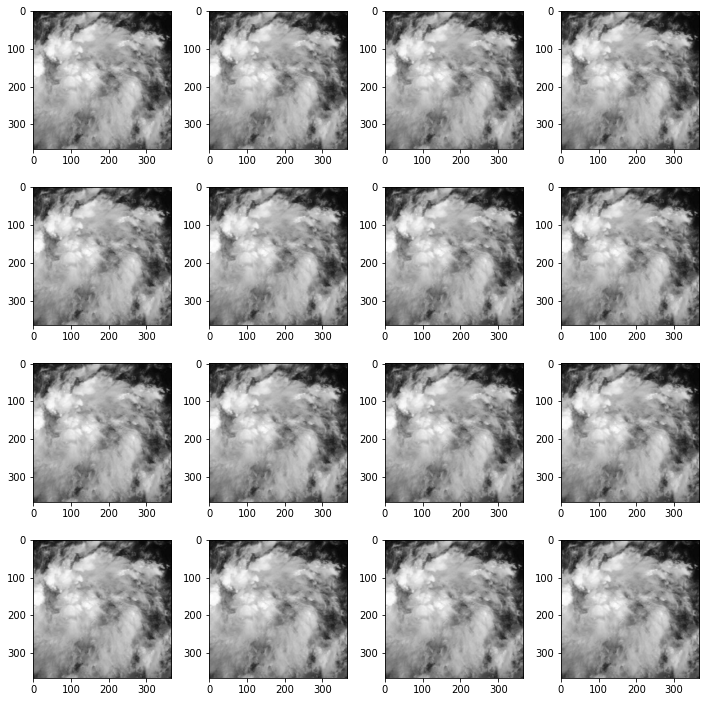

In [11]:
for image in full_loader:
    visualisation.show_batch(image,4,4)
    break

Storing our images in an array

In [12]:
# Here we store the images in an array for the whole dataset, training, validation and testing
image_id_full, images_full, labels_full = dataprocessing.Loader_to_1D_array(full_loader, 366*366)
image_id, images, labels = dataprocessing.Loader_to_1D_array(train_loader, 366*366)
image_id_val, images_val, labels_val = dataprocessing.Loader_to_1D_array(val_loader, 366*366)
image_id_test, images_test, labels_test = dataprocessing.Loader_to_1D_array(test_loader, 366*366)

Sanity check whether our data has been normalized

In [20]:
full_image = torch.stack(images_full)
print(torch.mean(full_image))
print(torch.std(full_image))

tensor(-4.4495e-08)
tensor(1.)


## Putting the data into the right format for training and testing

**Note**: tw is train window

Our algorithm involves putting an image into the neural network and predicting the next image. Hence, we will split the training and labelling data in a manner that we take the first tw images take the next image as the testing data.

The network is inspired from https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/
where they predict a time series data, but in our case we are predicting a whole array rather than an integer.

For example, if we had 10 datapoints in total and our tw value is 2 then,
our training and labelling data would be

(1,2), 3

(2,3), 4

(3,4), 5

and so on..

In this case we choose the tw value to be 1

In [15]:
training, labeling = dataprocessing.create_inout_seq(images, 1)
# validating, labeling_val = create_inout_seq(images_val, 1)
testing, labeling_test = dataprocessing.create_inout_seq(images_test, 1)

In [16]:
storm_train = TensorDataset(training, labeling)
# storm_val = TensorDataset(validating, labeling_val)
storm_test = TensorDataset(testing, labeling_test)

## Training our model

### Using MSE

We will train our model with 2 different metric, the MSE and the SSIM metric.

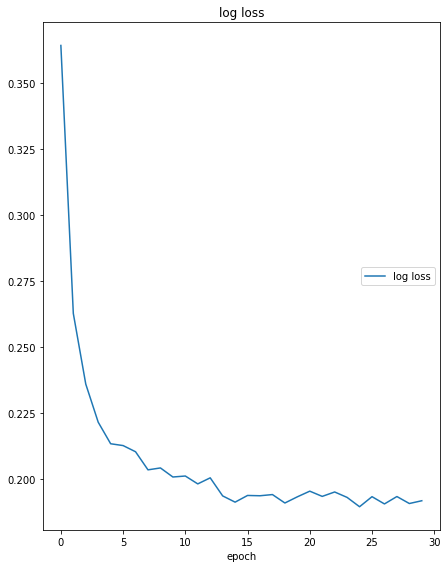

log loss
	log loss         	 (min:    0.190, max:    0.364, cur:    0.192)
400.3631646633148


In [17]:
from livelossplot import PlotLosses
import time
fc_lstm.set_seed(42)
epochs = 30
batch_size = 1
model = fc_lstm.LSTM(366*366, 150, 366*366).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train_loader = DataLoader(storm_train, batch_size=batch_size, shuffle=True, num_workers=0)
# val_loader = DataLoader(storm_val, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(storm_test, batch_size=batch_size, shuffle=True, num_workers=0)
# model.hidden_layer_size = batch_size

liveloss = PlotLosses()
start = time.time()
for i in range(epochs):
    logs = {}
    train_loss = fc_lstm.train_lstm_mse(model, optimizer, criterion, train_loader)
    # Additional line for giving logs in liveloss plot
    logs['' + 'log loss'] = train_loss.item()

    # validation_loss= fc_lstm.validate_mse(model, criterion, val_loader)
    # # Additional line for giving logs in liveloss plot
    # logs['val_' + 'log loss'] = validation_loss.item()

    liveloss.update(logs)
    liveloss.draw()

end = time.time()
print(end - start)

# Using SSIM

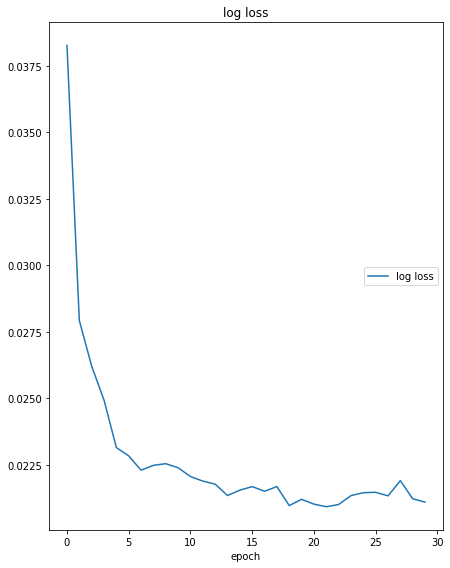

log loss
	log loss         	 (min:    0.021, max:    0.038, cur:    0.021)
441.3669080734253


In [19]:
from livelossplot import PlotLosses
import time
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
fc_lstm.set_seed(42)
epochs = 30
batch_size = 1
model_ssim = fc_lstm.LSTM(366*366, 150, 366*366).to(device)
criterion = ssim
optimizer = torch.optim.Adam(model_ssim.parameters(), lr=0.01)
train_loader = DataLoader(storm_train, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(storm_test, batch_size=batch_size, shuffle=True, num_workers=0)

liveloss = PlotLosses()
start = time.time()
for i in range(epochs):
    logs = {}
    train_loss = fc_lstm.train_lstm_SSIM(model_ssim, optimizer, criterion, train_loader)
    # Additional line for giving logs in liveloss plot
    logs['' + 'log loss'] = train_loss.item()

    # validation_loss= validate(model, criterion, val_loader)
    # # Additional line for giving logs in liveloss plot
    # logs['val_' + 'log loss'] = validation_loss.item()

    liveloss.update(logs)
    liveloss.draw()

end = time.time()
print(end - start)
# print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

# Prediction

## Previous 5 images

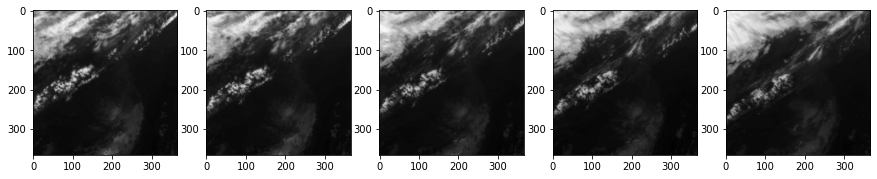

In [21]:
import numpy as np
import matplotlib.pyplot as plt

w = 10
h = 10
current = 638
fig = plt.figure(figsize=(15, 15))
columns = 5
rows = 1
for i in range(1, columns*rows +1):
    img = images_full[current+i:current+i+1][0].reshape(366,366)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img,cmap="gray")
plt.show()

## Future 5 predictions

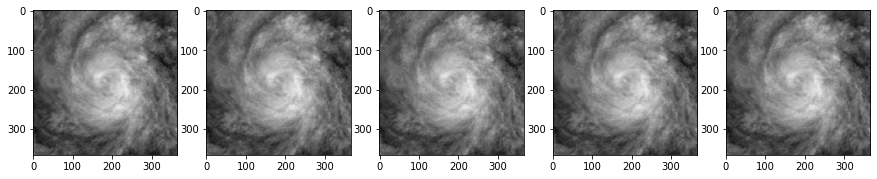

In [21]:
import numpy as np
import matplotlib.pyplot as plt

w = 10
h = 10
fig = plt.figure(figsize=(15, 15))
columns = 5
rows = 1
y_pred, ys= fc_lstm.evaluate(model, test_loader)
y_pred = y_pred.reshape(5,366,366)
for i in range(1, columns*rows +1):
    # print(np.shape(y_pred))
    fig.add_subplot(rows, columns, i)
    plt.imshow(y_pred[i-1],cmap="gray")
plt.show()

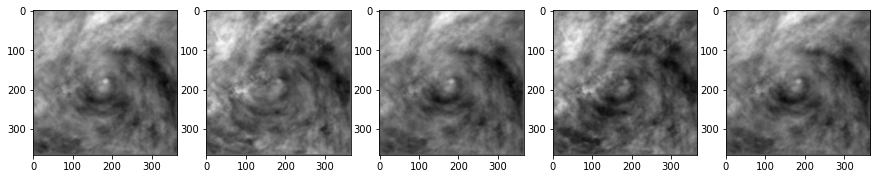

In [23]:
import numpy as np
import matplotlib.pyplot as plt

w = 10
h = 10
fig = plt.figure(figsize=(15, 15))
columns = 5
rows = 1
y_pred, ys= fc_lstm.evaluate(model_ssim, test_loader)
y_pred = y_pred.reshape(5,366,366)
for i in range(1, columns*rows +1):
    # print(np.shape(y_pred))
    fig.add_subplot(rows, columns, i)
    plt.imshow(y_pred[i-1],cmap="gray")
plt.show()

MSE

In [19]:
# Load the test data using DataLoader
criterion = nn.MSELoss()
test_loader = DataLoader(storm_test, batch_size=batch_size, shuffle=True, num_workers=0)

# Using the recently trained model to validate on the test_loader dataset
test_loss = fc_lstm.validate_mse(model, criterion, test_loader)    
print("Avg. Test Loss: ", test_loss.item())

Avg. Test Loss:  0.037699148058891296


SSIM

In [25]:
criterion = ssim

# Load the test data using DataLoader
test_loader = DataLoader(storm_test, batch_size=batch_size, shuffle=True, num_workers=0)

# Using the recently trained model to validate on the test_loader dataset
test_loss = fc_lstm.validate_SSIM(model, criterion, test_loader)    
print("Avg. Test Loss: ", test_loss.item())

Avg. Test Loss:  0.03743206337094307


## The actual Next 5 predictions

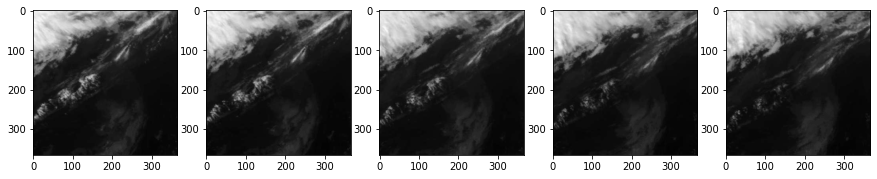

In [26]:
import numpy as np
import matplotlib.pyplot as plt

current = 642
w = 10
h = 10
fig = plt.figure(figsize=(15, 15))
columns = 5
rows = 1
for i in range(1, columns*rows +1):
    img = images_full[current+i:current+i+1][0].reshape(366,366)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img,cmap="gray")
plt.show()